In [1]:
import json
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class config:
    epochs = 100
    batch_size = 16
    test_batch_size = 16
    learning_rate = 1e-3
    fMRI_mask_path = '../input/trends-assessment-prediction/fMRI_mask.nii'
    root_train_path = '../input/trends-assessment-prediction/fMRI_train'
    root_test_path = '../input/trends-assessment-prediction/fMRI_test'
    num_folds = 5
    seed = 2020
    verbose = False
    verbose_step = 1
    num_workers = 4
    test_num_workers = 4
    target = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
    weight = [0.3, 0.175, 0.175, 0.175, 0.175]
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))


In [15]:
target_id = 0
fold = 2
file_No = 3
r_type = "ridge"
fname = f"ridge_results/pred_{config.target[target_id]}_No{file_No}_CV.csv"
print(fname)

ridge_results/pred_age_No3_CV.csv


In [16]:
df = pd.read_csv('../input/trends-assessment-prediction/train_scores.csv')
df.describe()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,15909.667007,50.034068,51.474692,59.244132,47.325130,51.905658
std,3411.775315,13.539881,10.188354,11.387595,11.124863,11.839203
min,10001.000000,14.257265,15.769168,1.021874,0.991172,0.815285
25%,12961.000000,40.129361,44.781240,52.396805,40.122682,44.514880
50%,15925.000000,50.427747,51.847306,60.052535,47.811205,52.572032
75%,18886.000000,59.580851,58.495576,67.142611,55.058014,59.910146
max,21754.000000,84.491113,81.325580,94.702874,82.164478,94.509903


In [17]:
file_No = 3
test_df = pd.DataFrame(np.zeros((5877, 5)), columns=config.target)
val_df = pd.DataFrame(np.zeros((5877, 6)), columns=["Id"] + config.target)
val_df["Id"] = df["Id"]
for target_id in range(5):
    # fname = f"output/test_{config.target[target_id]}fold{fold}_No{file_No}.csv"
    fname = f"ridge_results/pred_{config.target[target_id]}_No{file_No}_CV.csv"
    print(fname)
    test_df[config.target[target_id]] = pd.read_csv(fname)[config.target[target_id]+"_pred"]
    val_fname = f"ridge_results/val_{config.target[target_id]}_No{file_No}_CV.csv"
    val_df[config.target[target_id]] = pd.read_csv(val_fname)[config.target[target_id]+"_pred"]
submission_file = f'ensemble/valid_{r_type}_No{file_No}.csv'
for target_id in range(5):
    val_df.rename(columns={config.target[target_id]: f"pre_{r_type}_raw_" + config.target[target_id]}, inplace=True)
    test_df.rename(columns={config.target[target_id]: f"pre_{r_type}_raw_" + config.target[target_id]}, inplace=True)
val_df.to_csv(submission_file, index=False)
test_df.describe()



ridge_results/pred_age_No3_CV.csv
ridge_results/pred_domain1_var1_No3_CV.csv
ridge_results/pred_domain1_var2_No3_CV.csv
ridge_results/pred_domain2_var1_No3_CV.csv
ridge_results/pred_domain2_var2_No3_CV.csv


,pre_ridge_raw_age,pre_ridge_raw_domain1_var1,pre_ridge_raw_domain1_var2,pre_ridge_raw_domain2_var1,pre_ridge_raw_domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.102401,51.544221,59.265919,47.030555,52.070230
std,10.307790,3.257404,1.310536,2.621270,2.303485
min,16.664608,40.137236,54.490867,37.517069,42.940131
25%,41.722780,49.348620,58.385980,45.228361,50.527635
50%,48.843128,51.601936,59.298175,46.971464,52.041239
75%,56.396698,53.799062,60.140605,48.832149,53.592914
max,83.852015,63.655912,63.948632,56.983702,61.128749


In [20]:
val_df

,Id,pre_ridge_raw_age,pre_ridge_raw_domain1_var1,pre_ridge_raw_domain1_var2,pre_ridge_raw_domain2_var1,pre_ridge_raw_domain2_var2
0,10001,60.941077,54.596251,58.331412,47.900594,51.504470
1,10002,56.273971,52.660702,57.645988,46.634553,52.587057
2,10004,51.985832,52.545051,59.134693,48.215794,49.814583
3,10005,60.782233,56.176356,60.438799,49.314980,52.713211
4,10007,43.718533,49.729905,58.011787,46.884856,51.646510
...,...,...,...,...,...,...
5872,21746,33.681549,49.477765,59.760810,45.275421,49.109376
5873,21747,51.478162,48.508501,59.348302,48.173059,53.912979
5874,21750,41.290475,49.435824,60.918935,45.823637,52.207321
5875,21752,55.207767,55.041960,58.910069,48.851521,52.222252


In [18]:
# train_std = df[config.target].std()
# train_mean = df[config.target].mean()
# val_std = val_df.std()
# val_mean = val_df.mean()
# test_std = test_df.std()
# test_mean = test_df.mean()

# val_df = (val_df - val_mean) / val_std * train_std + val_mean
# test_df = (test_df - test_mean) / test_std * train_std + val_mean

# val_df.describe()

In [22]:
all_score = 0.0
for i in range(5):
    not_null = df[config.target[i]].notnull().values
    y_true = df.iloc[not_null, i + 1].values
    y_pred = val_df.iloc[not_null, i + 1].values
    score = metric(y_true, y_pred) * config.weight[i]
    all_score += score
    print(f"{config.target[i]}:{score:.5f}")
print(f"CV score:{all_score:.5f}")

age:0.04293
domain1_var1:0.02641
domain1_var2:0.02638
domain2_var1:0.03177
domain2_var2:0.03082
CV score:0.15831


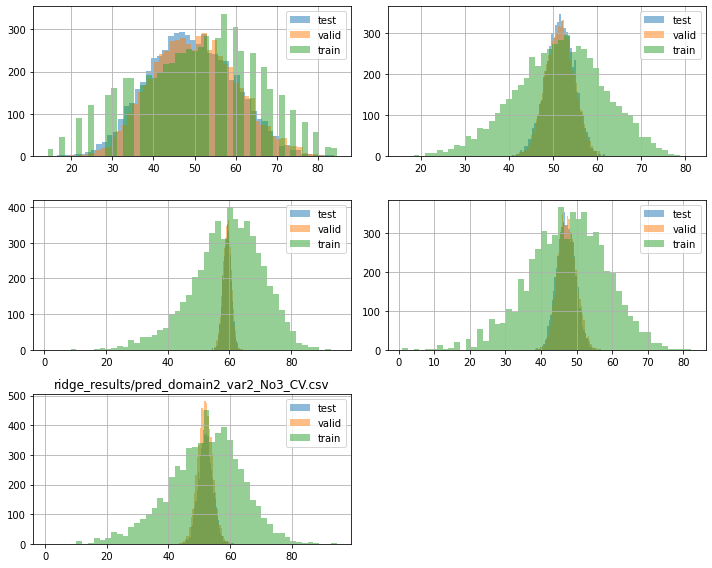

In [24]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    test_df.iloc[:, i].hist(bins=50, alpha=0.5, label="test")
    val_df.iloc[:, i + 1].hist(bins=50, alpha=0.5, label="valid")
    df.iloc[:, i + 1].hist(bins=50, alpha=0.5, label="train")
    plt.legend()
plt.title(fname)
plt.tight_layout()
plt.savefig(f'pictures/{r_type}_No{file_No}.png')

In [25]:
list1 = os.listdir(config.root_test_path)
list2 = sorted(list1)
test_df["Id"] = list2
test_df["Id"] = test_df["Id"].map(lambda x: x[:-4])
test_df.set_index("Id", drop=True, inplace=True)
submission_file = f'ensemble/test_{r_type}_No{file_No}.csv'
test_df.to_csv(submission_file)

# %%

df_long = test_df.stack().reset_index()
df_long.rename(columns={'level_1': 'target', 0: 'Predicted'}, inplace=True)
df_long["Id"] = df_long["Id"] + "_" + df_long["target"]
df_long.drop("target", axis=1, inplace=True)
submission_file = f'submission/submission_{r_type}_No{file_No}.csv'
print(submission_file)
df_long.to_csv(submission_file, index=False)
df_long

submission/submission_ridge_No3.csv


,Id,Predicted
0,10003_pre_ridge_raw_age,57.640028
1,10003_pre_ridge_raw_domain1_var1,49.191342
2,10003_pre_ridge_raw_domain1_var2,60.048948
3,10003_pre_ridge_raw_domain2_var1,49.958692
4,10003_pre_ridge_raw_domain2_var2,57.036231
...,...,...
29380,21753_pre_ridge_raw_age,40.238160
29381,21753_pre_ridge_raw_domain1_var1,42.674724
29382,21753_pre_ridge_raw_domain1_var2,60.221405
29383,21753_pre_ridge_raw_domain2_var1,44.886670


In [26]:
test_df

,pre_ridge_raw_age,pre_ridge_raw_domain1_var1,pre_ridge_raw_domain1_var2,pre_ridge_raw_domain2_var1,pre_ridge_raw_domain2_var2
Id,,,,,
10003,57.640028,49.191342,60.048948,49.958692,57.036231
10006,62.484410,54.158152,58.700856,48.903053,51.989313
10010,36.980785,49.862828,59.959399,45.003807,53.087505
10011,51.448546,51.923209,60.282690,48.334264,50.375376
10012,52.108823,54.652694,55.473489,46.109041,58.985471
...,...,...,...,...,...
21745,39.781076,50.642519,58.031537,45.402942,54.018275
21748,53.728557,57.449213,60.045842,47.846719,51.906732
21749,40.040357,47.097644,58.921558,45.500147,51.670896


In [9]:
fnc = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading = pd.read_csv("../input/trends-assessment-prediction/loading.csv")
df = loading.merge(fnc, on="Id", how="left")
columns = list(df.columns[1:])
print(columns[:5], columns[-5:])


['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26'] ['CBN(4)_vs_CBN(13)', 'CBN(7)_vs_CBN(13)', 'CBN(4)_vs_CBN(18)', 'CBN(7)_vs_CBN(18)', 'CBN(7)_vs_CBN(4)']


In [10]:
n_features =[0, 2, 9, 0, 0]
targets = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
data = {}
for i in range(5):
    value = columns[:len(columns) - n_features[0]]
    key = f"{targets[i]}_No{file_No}_columns"
    data[key] = value


In [11]:
json_path = f"ensemble/ridge_No{file_No}_columns.json"
with open(json_path, 'w') as f:
    json.dump(data, f, indent=4)

In [12]:
with open(json_path) as f:
    df = json.load(f)
